<a href="https://colab.research.google.com/github/CherniNada12/GNN-AIDS-Mol-cules-Classification/blob/main/GNN-AIDS-Mol%C3%A9cules-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="
    background-color: #f0f8ff;
    border-left: 6px solid #1e90ff;
    padding: 20px;
    border-radius: 10px;
    font-family: Arial, sans-serif;
    line-height: 1.6;
    max-width: 800px;
    margin-bottom: 20px;
">
    <h2 style="color: #1e90ff; margin-top: 0;">📘 Présentation du dataset <strong>AIDS</strong></h2>
    <p>Ce dataset contient des <strong>graphes moléculaires</strong> représentant différentes molécules testées pour leur <strong>activité contre le virus du SIDA (HIV)</strong>. Chaque graphe correspond à une molécule, où :</p>
    <ul style="color: #333;">
        <li><strong>Les nœuds (nodes)</strong> représentent des atomes.</li>
        <li><strong>Les arêtes (edges)</strong> représentent des liaisons chimiques entre ces atomes.</li>
    </ul>
    <p>L’objectif est de <strong>classifier les molécules</strong> selon leur <strong>activité biologique</strong> :</p>
    <ul style="color: #333;">
        <li><strong>0</strong> → molécule <span style="color: green; font-weight: bold;">active</span> (agit contre le VIH)</li>
        <li><strong>1</strong> → molécule <span style="color: red; font-weight: bold;">inactive</span></li>
    </ul>
</div>


<div style="
    background-color: #fffaf0;
    border-left: 6px solid #ff8c00;
    padding: 20px;
    border-radius: 10px;
    font-family: Arial, sans-serif;
    line-height: 1.8;
    max-width: 800px;
    margin-bottom: 20px;
    font-size: 18px;
">
    <h2 style="color: #ff8c00; margin-top: 0; font-size: 24px;">📂 Fichiers du dataset</h2>
    <table style="
        width: 100%;
        border-collapse: collapse;
        text-align: left;
        font-size: 30px;
    ">
        <thead>
            <tr style="background-color: #ffe4b5;">
                <th style="padding: 12px; border-bottom: 2px solid #ff8c00;">Fichier</th>
                <th style="padding: 12px; border-bottom: 2px solid #ff8c00;">Description</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td style="padding: 12px; border-bottom: 1px solid #ddd;">AIDS_graph_indicator.txt</td>
                <td style="padding: 12px; border-bottom: 1px solid #ddd;">Indique à quel graphe appartient chaque nœud</td>
            </tr>
            <tr style="background-color: #fff5e6;">
                <td style="padding: 12px; border-bottom: 1px solid #ddd;">AIDS_graph_labels.txt</td>
                <td style="padding: 12px; border-bottom: 1px solid #ddd;">Label global (0 = active, 1 = inactive)</td>
            </tr>
            <tr>
                <td style="padding: 12px; border-bottom: 1px solid #ddd;">AIDS_node_labels.txt</td>
                <td style="padding: 12px; border-bottom: 1px solid #ddd;">Type d’atome (38 types encodé en entier de 0 ==> 37)</td>
            </tr>
            <tr style="background-color: #fff5e6;">
                <td style="padding: 12px; border-bottom: 1px solid #ddd;">AIDS_node_attributes.txt</td>
                <td style="padding: 12px; border-bottom: 1px solid #ddd;">Attributs des nœuds : chem(propriétés chimiques), charge électrique, x, y</td>
            </tr>
            <tr>
                <td style="padding: 12px; border-bottom: 1px solid #ddd;">AIDS_A.txt</td>
                <td style="padding: 12px; border-bottom: 1px solid #ddd;">Matrice d'adjacence: Liste des arêtes (from_node, to_node)</td>
            </tr>
            <tr style="background-color: #fff5e6;">
                <td style="padding: 12px; border-bottom: 1px solid #ddd;">AIDS_edge_labels.txt</td>
                <td style="padding: 12px; border-bottom: 1px solid #ddd;">Type de liaison chimique (valence: Simple:0 , Double:1 ou Triple:2)</td>
            </tr>
        </tbody>
    </table>
</div>


# **Imports nécessaires**

In [ ]:
import numpy as np
import networkx as nx
from collections import defaultdict, Counter
import os
import numpy as np
import networkx as nx
from tqdm import tqdm

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# **Connexion à Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = "/content/drive/MyDrive/AIDS/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2. Lire les fichiers**

In [ ]:
# Charger graph_indicator
graph_indicator = np.loadtxt(base_path + "AIDS_graph_indicator.txt", dtype=int)

# Charger labels des graphes
graph_labels = np.loadtxt(base_path + "AIDS_graph_labels.txt", dtype=int)

# Charger labels des noeuds
node_labels = np.loadtxt(base_path + "AIDS_node_labels.txt", dtype=int)

# Charger attributs des noeuds
node_attributes = np.loadtxt(base_path + "AIDS_node_attributes.txt", delimiter=",")
print("Node attributes shape :", node_attributes.shape)

# Charger edges
edges = np.loadtxt(base_path + "AIDS_A.txt", dtype=int, delimiter=",")

# Charger edge labels
edge_labels = np.loadtxt(base_path + "AIDS_edge_labels.txt", dtype=int)

Node attributes shape : (31385, 4)


1. Vérifier que le nombre de node labels = number of nodes

In [ ]:
print("node_labels:", len(node_labels))
print("node_attributes:", node_attributes.shape[0])
print("graph_indicator:", len(graph_indicator))
#Les trois doivent être égaux = 31385.

node_labels: 31385
node_attributes: 31385
graph_indicator: 31385


2. Vérifier la cohérence edges ↔ edge_labels

In [ ]:
print("nb edges in A.txt :", len(edges))
print("nb edge_labels :", len(edge_labels))
#Ils doivent être égaux.

nb edges in A.txt : 64780
nb edge_labels : 64780


3. Vérifier répartition nœuds par graphe

In [ ]:
print("Total nodes         :", len(node_labels))
print("Node attributes      :", node_attributes.shape)
print("Graph indicator      :", len(graph_indicator))
print("Edges                :", edges.shape)
print("Edge labels          :", len(edge_labels))
print("Graph labels (#graphs):", len(graph_labels))

assert len(node_labels) == node_attributes.shape[0] == len(graph_indicator), "Mismatch in node data!"
assert edges.shape[0] == len(edge_labels), "Mismatch in edge data!"

print("\n✔ Vérification des shapes OK")


Total nodes         : 31385
Node attributes      : (31385, 4)
Graph indicator      : 31385
Edges                : (64780, 2)
Edge labels          : 64780
Graph labels (#graphs): 2000

✔ Vérification des shapes OK


# **3. Construire les graphes NetworkX**

In [ ]:
num_graphs = max(graph_indicator)
graphs = [nx.Graph() for _ in range(num_graphs)]

# --- Ajouter les noeuds ---
for nid in range(1, len(graph_indicator) + 1):
    gid = graph_indicator[nid - 1] - 1  # index 0-based

    graphs[gid].add_node(
        nid,
        label=int(node_labels[nid - 1]),
        attr=node_attributes[nid - 1]
    )

# --- Ajouter les arêtes ---
for i, (u, v) in enumerate(edges):
    gid_u = graph_indicator[u - 1] - 1
    gid_v = graph_indicator[v - 1] - 1

    if gid_u == gid_v:  # sécurité : on n'ajoute que dans le même graphe
        graphs[gid_u].add_edge(
            u, v,
            label=int(edge_labels[i])
        )
    else:
        print(f"⚠ Avertissement : edge ({u},{v}) entre graph {gid_u} et {gid_v}")


### **Affichage des Graphes**

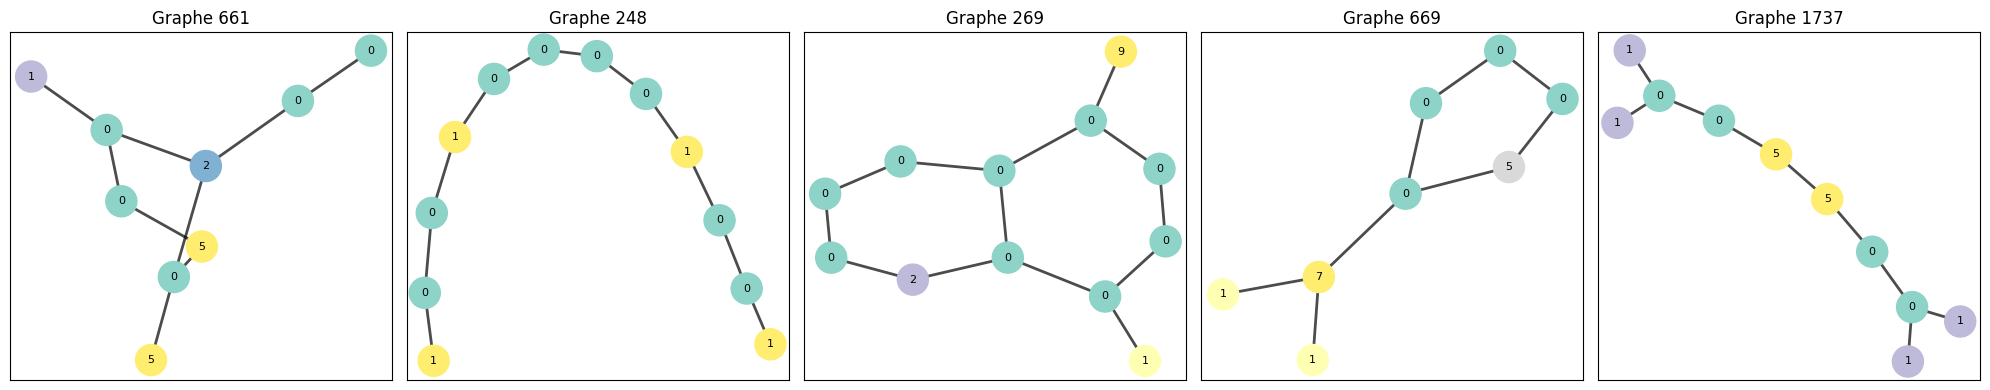

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import random

def show_multigraphs(graphs_list, titles=None):
    n = len(graphs_list)
    plt.figure(figsize=(4*n, 4))

    for i, G in enumerate(graphs_list):
        plt.subplot(1, n, i+1)
        pos = nx.spring_layout(G, seed=42)  # positions des nœuds

        # Node labels et couleurs
        node_labels = nx.get_node_attributes(G, 'label')
        node_colors = [G.nodes[n]['label'] for n in G.nodes()]

        nx.draw_networkx_nodes(
            G, pos,
            node_size=500,
            node_color=node_colors,
            cmap=plt.cm.Set3
        )
        nx.draw_networkx_labels(
            G, pos,
            labels=node_labels,
            font_size=8,
            font_color='black'
        )

        # Dessiner les arêtes du MultiGraph
        for u, v, data in G.edges(data=True):
            nx.draw_networkx_edges(
                G, pos,
                edgelist=[(u, v)],
                width=2,
                alpha=0.7
            )

        if titles:
            plt.title(titles[i])

    plt.tight_layout()
    plt.show()


# --- Sélectionner 5 graphes au hasard pour affichage ---
indices = random.sample(range(len(graphs)), 5)
selected_graphs = [graphs[i] for i in indices]
titles = [f"Graphe {i}" for i in indices]

# Afficher les graphes
show_multigraphs(selected_graphs, titles)


### **Vérification de la construction des graphes**

**Vérification qualitative des graphes**

In [ ]:
sizes = [G.number_of_nodes() for G in graphs]
edge_sizes = [G.number_of_edges() for G in graphs]

print("\n--- Statistiques des graphes ---")
print("Nb graphes :", len(graphs))
print("Min nodes :", np.min(sizes))
print("Max nodes :", np.max(sizes))
print("Avg nodes :", np.mean(sizes))
print("Min edges :", np.min(edge_sizes))
print("Max edges :", np.max(edge_sizes))
print("Avg edges :", np.mean(edge_sizes))



--- Statistiques des graphes ---
Nb graphes : 2000
Min nodes : 2
Max nodes : 95
Avg nodes : 15.6925
Min edges : 1
Max edges : 103
Avg edges : 16.195


**Enregistrer les graphes dans Google Drive**

In [ ]:
import os
import networkx as nx
import pickle # Import the pickle module

# Dossier de sauvegarde
save_dir = "/content/drive/MyDrive/AIDS/AIDS_processed_graphs/"
os.makedirs(save_dir, exist_ok=True)

# Sauvegarder chaque graphe individuellement
for i, G in enumerate(graphs):
    file_path = os.path.join(save_dir, f"graph_{i}.gpickle")
    with open(file_path, 'wb') as fp: # Open in binary write mode
        pickle.dump(G, fp) # Use pickle.dump to save the graph

print(f"{len(graphs)} graphes sauvegardés dans {save_dir}")

KeyboardInterrupt: 

# **Analyse Exploratoire Complète (EDA) des Graphes**

In [ ]:
import numpy as np
import networkx as nx
from collections import Counter

# --- Préparer les données ---
num_graphs = len(graphs)
node_counts = np.array([G.number_of_nodes() for G in graphs])
edge_counts = np.array([G.number_of_edges() for G in graphs])
densities = np.array([nx.density(G) for G in graphs])
clust = np.array([nx.average_clustering(G) for G in graphs])

# Types d’atomes
all_atoms = [G.nodes[n]["label"] for G in graphs for n in G.nodes()]
atom_counts = Counter(all_atoms)

# Types de liaisons (valence)
all_bonds = [G.edges[e]["label"] for G in graphs for e in G.edges()]
bond_counts = Counter(all_bonds)

# Distribution des labels des graphes (0=Active, 1=Inactive)
graph_label_counts = Counter(graph_labels)

# --- Affichage résumé ---
print("=== Résumé du dataset AIDS ===\n")
print(f"Nombre total de graphes : {num_graphs}\n")

print(f"Nombre de nœuds par graphe : min={node_counts.min()}, max={node_counts.max()}, moyenne={node_counts.mean():.2f}")
print(f"Nombre d'arêtes par graphe : min={edge_counts.min()}, max={edge_counts.max()}, moyenne={edge_counts.mean():.2f}")
print(f"Densité des graphes : min={densities.min():.4f}, max={densities.max():.4f}, moyenne={densities.mean():.4f}")
print(f"Coefficient de clustering moyen : {clust.mean():.4f}\n")

print("Distribution des labels des graphes :")
for label, count in graph_label_counts.items():
    print(f"  Label {label}: {count} graphes")

print("\nTypes d'atomes présents (10 premiers) :")
for atom, count in list(atom_counts.items())[:10]:
    print(f"  Atome {atom}: {count} occurrences")

bond_names = {0: "simple", 1: "double", 2: "triple"}

print("\nTypes de liaisons (valence) présents :")
for bond, count in bond_counts.items():
    name = bond_names.get(bond, f"autre ({bond})")
    print(f"  Valence {bond} ({name}): {count} occurrences")

=== Résumé du dataset AIDS ===

Nombre total de graphes : 2000

Nombre de nœuds par graphe : min=2, max=95, moyenne=15.69
Nombre d'arêtes par graphe : min=1, max=103, moyenne=16.20
Densité des graphes : min=0.0231, max=1.0000, moyenne=0.1935
Coefficient de clustering moyen : 0.0072

Distribution des labels des graphes :
  Label 0: 400 graphes
  Label 1: 1600 graphes

Types d'atomes présents (10 premiers) :
  Atome 0: 19564 occurrences
  Atome 1: 5492 occurrences
  Atome 2: 4149 occurrences
  Atome 3: 385 occurrences
  Atome 4: 78 occurrences
  Atome 5: 1253 occurrences
  Atome 6: 16 occurrences
  Atome 7: 109 occurrences
  Atome 8: 60 occurrences
  Atome 9: 42 occurrences

Types de liaisons (valence) présents :
  Valence 0 (simple): 23835 occurrences
  Valence 1 (double): 8375 occurrences
  Valence 2 (triple): 180 occurrences


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from collections import Counter
import networkx as nx

# --- Préparer les données ---
node_counts = np.array([G.number_of_nodes() for G in graphs])
edge_counts = np.array([G.number_of_edges() for G in graphs])
densities = np.array([nx.density(G) for G in graphs])
clust = [nx.average_clustering(G) for G in graphs]
mean_clust = np.mean(clust)

# Types d’atomes et liaisons
all_atoms, all_bonds = [], []
for G in graphs:
    all_atoms.extend([G.nodes[n].get("label", -1) for n in G.nodes()])
    all_bonds.extend([G.edges[e].get("label", 0) for e in G.edges()])

atom_counts = Counter(all_atoms)
atom_labels = sorted(atom_counts.keys())
atom_values = [atom_counts[k] for k in atom_labels]

bond_counts = Counter(all_bonds)
bond_labels = sorted(bond_counts.keys())
bond_values = [bond_counts[k] for k in bond_labels]

# Labels de graphes (classe : active/inactive)
label_counts = Counter(graph_labels)
labels = list(label_counts.keys())
counts = list(label_counts.values())

# Taille de la plus grande composante
components_sizes = [len(max(nx.connected_components(G), key=len)) for G in graphs]

# --- Figure interactive 2 lignes × 4 colonnes ---
fig = make_subplots(
    rows=2, cols=4,
    subplot_titles=(
        "Distribution des labels (Active/Inactive)",
        "Nombre de nœuds par graphe",
        "Nombre d'arêtes par graphe",
        "Densité des graphes",
        "Coefficient de clustering",
        "Distribution des types d'atomes (DotPlot)",
        "Distribution des types de liaisons",
        "Taille de la plus grande composante"
    )
)

# 1️ Distribution des labels (Active/Inactive)
fig.add_trace(go.Bar(
    x=labels,
    y=counts,
    text=counts,
    textposition='auto',
    marker_color=['#A0C4FF', '#FFADAD']  # bleu pastel, rose pastel
), row=1, col=1)

# 2️ Nombre de nœuds
fig.add_trace(go.Histogram(x=node_counts, nbinsx=30, marker_color="#4a90e2"), row=1, col=2)

# 3️ Nombre d'arêtes
fig.add_trace(go.Histogram(x=edge_counts, nbinsx=30, marker_color="#f39c12"), row=1, col=3)

# 4️ Densité
fig.add_trace(go.Histogram(x=densities, nbinsx=30, marker_color="#2ecc71"), row=1, col=4)

# 5️ Coefficient de clustering
fig.add_trace(go.Histogram(x=clust, nbinsx=30, marker_color="#1abc9c"), row=2, col=1)
fig.add_vline(
    x=mean_clust,
    line_dash="dash",
    line_color="red",
    line_width=2,
    annotation_text=f"Moyenne = {mean_clust:.4f}",
    annotation_position="top right",
    row=2, col=1
)

# 6️ Distribution des types d'atomes (DotPlot)
fig.add_trace(go.Scatter(
    x=atom_labels,
    y=atom_values,
    mode="markers",
    marker=dict(
        size=14,
        color="lightseagreen",
        line=dict(width=1, color='darkgreen')
    ),
    hovertemplate="Atome: %{x}<br>Occurrences: %{y}<extra></extra>"
), row=2, col=2)

# 7️ Distribution des types de liaisons
fig.add_trace(go.Bar(x=bond_labels, y=bond_values, marker_color="#ff9999"), row=2, col=3)

# 8️ Taille de la plus grande composante
fig.add_trace(go.Histogram(x=components_sizes, nbinsx=20, marker_color="#9b59b6"), row=2, col=4)

# --- Layout général ---
fig.update_layout(
    title_text="EDA du Dataset AIDS (avec Distribution des Classes en tête)",
    showlegend=False,
    height=750,
    width=1400,
    template="plotly_white",
    bargap=0.18
)

# --- Labels d’axes ---
titles = [
    ("Classe (0=Active, 1=Inactive)", "Nombre de graphes"),
    ("Nombre de nœuds", "Nombre de graphes"),
    ("Nombre d'arêtes", "Nombre de graphes"),
    ("Densité", "Nombre de graphes"),
    ("Coefficient de clustering", "Nombre de graphes"),
    ("Label d'atome", "Occurrences"),
    ("Label de liaison (valence)", "Occurrences"),
    ("Nb nœuds (plus grande composante)", "Nombre de graphes")
]

r, c = 1, 1
for xlab, ylab in titles:
    fig.update_xaxes(title_text=xlab, row=r, col=c)
    fig.update_yaxes(title_text=ylab, row=r, col=c)
    c += 1
    if c > 4:
        c, r = 1, r + 1

fig.show()


Vérification connectivité

In [ ]:
from networkx.algorithms.components import is_connected
import plotly.graph_objects as go

# Comptage des graphes connectés et non connectés
connected = sum(is_connected(G) for G in graphs)
non_connected = len(graphs) - connected

print(f"Graphes connectés : {connected}/{len(graphs)}")
print(f"Graphes non connectés : {non_connected}/{len(graphs)}")

# Préparer les données pour le plot
labels = ["Connectés", "Non connectés"]
counts = [connected, non_connected]
colors = ["#A0C4FF", "#FFADAD"]  # pastel bleu et rose

# Créer le bar chart interactif
fig = go.Figure(data=[go.Bar(
    x=labels,
    y=counts,
    text=counts,
    textposition='auto',
    marker_color=colors
)])

fig.update_layout(
    title="Distribution des graphes connectés vs non connectés",
    xaxis_title="Type de graphe",
    yaxis_title="Nombre de graphes",
    width=500,
    height=400
)

fig.show()


Graphes connectés : 1811/2000
Graphes non connectés : 189/2000


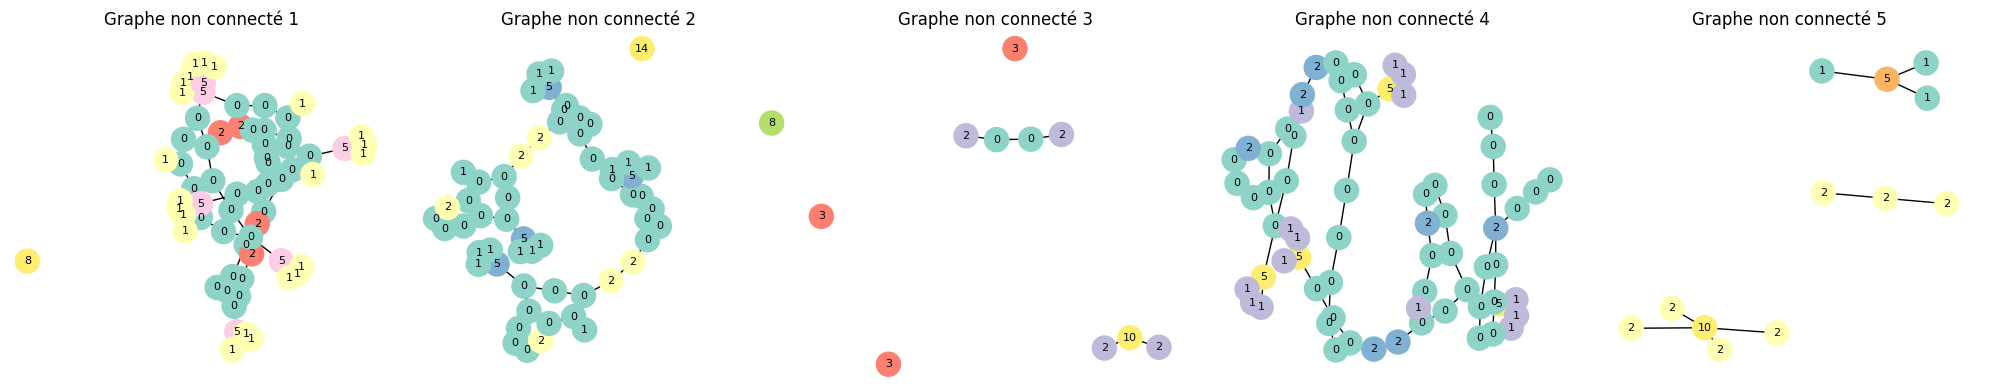

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from networkx.algorithms.components import is_connected

# Filtrer les graphes non connectés
non_connected_graphs = [G for G in graphs if not is_connected(G)]

# Choisir 5 graphes au hasard (ou moins s'il y en a moins)
num_to_show = min(5, len(non_connected_graphs))
selected_graphs = random.sample(non_connected_graphs, num_to_show)

# Affichage côte à côte
plt.figure(figsize=(4*num_to_show, 4))
for i, G in enumerate(selected_graphs):
    plt.subplot(1, num_to_show, i+1)
    pos = nx.spring_layout(G, seed=42)  # positionnement
    node_labels = nx.get_node_attributes(G, 'label')
    node_colors = [G.nodes[n]['label'] for n in G.nodes()]

    nx.draw(
        G,
        pos,
        with_labels=True,
        labels=node_labels,
        node_size=300,
        node_color=node_colors,
        cmap=plt.cm.Set3,
        font_size=8
    )
    plt.title(f"Graphe non connecté {i+1}")

plt.tight_layout()
plt.show()


# **Préprocessing**

In [ ]:
import os
import shutil
import pickle
import networkx as nx
import numpy as np

processed_graphs = []
processed_labels = []
processed_features = [] if 'features' in locals() else None

for i, G in enumerate(graphs):
    # Vérifier si le graphe est connecté
    if not nx.is_connected(G):
        # On ignore complètement ce graphe et toutes ses infos
        continue

    # Garder les coordonnées originales des noeuds si elles existent
    if 'attr' in G.nodes[list(G.nodes())[0]]:
        coords = np.array([[G.nodes[n]['attr'][2], G.nodes[n]['attr'][3]] for n in G.nodes()])
        for idx, n in enumerate(G.nodes()):
            G.nodes[n]['attr'][2] = coords[idx, 0]
            G.nodes[n]['attr'][3] = coords[idx, 1]

    # Ajouter le graphe et toutes ses infos associées
    processed_graphs.append(G)
    processed_labels.append(graph_labels[i])  # utiliser graph_labels
    if processed_features is not None:
        processed_features.append(features[i])

print("Graphes connectés après preprocessing :", len(processed_graphs))

# --- Créer le dossier de sauvegarde (supprimer s'il existe) ---
save_dir = "/content/drive/MyDrive/AIDS/Afterprocessed_graphs/"
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)  # supprime tout le contenu du dossier
os.makedirs(save_dir)  # recrée le dossier vide

# --- Sauvegarder chaque graphe individuellement ---
for i, G in enumerate(processed_graphs):
    file_path = os.path.join(save_dir, f"graph_{i}.gpickle")
    with open(file_path, 'wb') as fp:
        pickle.dump(G, fp)

# --- Sauvegarder les autres infos associées ---
with open(os.path.join(save_dir, "labels.pkl"), 'wb') as fp:
    pickle.dump(processed_labels, fp)

if processed_features is not None:
    with open(os.path.join(save_dir, "features.pkl"), 'wb') as fp:
        pickle.dump(processed_features, fp)

print(f"{len(processed_graphs)} graphes et toutes leurs infos sauvegardés dans {save_dir}")


Graphes connectés après preprocessing : 1811
1811 graphes et toutes leurs infos sauvegardés dans /content/drive/MyDrive/AIDS/Afterprocessed_graphs/


# **Charger les graphes**

In [ ]:
import os
import pickle

save_dir = "/content/drive/MyDrive/AIDS/Afterprocessed_graphs/"

# --- Charger tous les graphes individuels ---
graph_files = sorted([f for f in os.listdir(save_dir) if f.startswith("graph_") and f.endswith(".gpickle")])
graphs = []
for f in graph_files:
    with open(os.path.join(save_dir, f), 'rb') as fp:
        graphs.append(pickle.load(fp))

# --- Charger les labels ---
with open(os.path.join(save_dir, "labels.pkl"), 'rb') as f:
    graph_labels = pickle.load(f)

# --- Optionnel : charger les features si elles existent ---
features_path = os.path.join(save_dir, "features.pkl")
if os.path.exists(features_path):
    with open(features_path, 'rb') as f:
        features = pickle.load(f)

print(f"Nombre de graphes chargés : {len(graphs)}")
print(f"Nombre de labels chargés : {len(graph_labels)}")
if 'features' in locals():
    print(f"Nombre de features chargés : {len(features)}")


Nombre de graphes chargés : 1811
Nombre de labels chargés : 1811


# **Split des données**

In [ ]:
from sklearn.model_selection import train_test_split

# Split des graphes et des labels
X_train, X_test, y_train, y_test = train_test_split(
    graphs,      # tes graphes
    graph_labels,          # tes labels
    test_size=0.2,         # 20% pour le test
    stratify=graph_labels, # garder la proportion des classes
    random_state=42        # pour la reproductibilité
)

print(f"Nombre de graphes d'entraînement : {len(X_train)}")
print(f"Nombre de graphes de test       : {len(X_test)}")


Nombre de graphes d'entraînement : 1448
Nombre de graphes de test       : 363


# **Étape 1 : Méthode classique**

## **Extraction**

Topologie de base : degrés, densité, clustering, nombre de nœuds et d’arêtes

Centralités : degree, betweenness, closeness (moyenne et écart-type)

Des mesures globales : transitivity, longueur moyenne des plus courts chemins

In [ ]:
import numpy as np
import networkx as nx
from collections import Counter

def extract_graph_features(G, num_node_chem=0, max_edge_label=3):
    """
    Extraction de features globales pour un graphe G, incluant :
    - topologie
    - centralités
    - features chimiques des nœuds (num_node_chem = nombre de dimensions chimiques par noeud)
    - edge labels (valence)

    Retourne un vecteur 1D de features numériques de longueur fixe.
    """
    features = []

    # --- 1. Topologie de base ---
    degrees = [d for _, d in G.degree()]
    features.append(np.mean(degrees))
    features.append(np.std(degrees))
    features.append(np.min(degrees))
    features.append(np.max(degrees))

    features.append(nx.density(G))
    features.append(nx.average_clustering(G))
    features.append(G.number_of_nodes())
    features.append(G.number_of_edges())

    # --- 2. Centralités ---
    degree_centrality = list(nx.degree_centrality(G).values())
    features.append(np.mean(degree_centrality))
    features.append(np.std(degree_centrality))

    betweenness = list(nx.betweenness_centrality(G).values())
    features.append(np.mean(betweenness))
    features.append(np.std(betweenness))

    closeness = list(nx.closeness_centrality(G).values())
    features.append(np.mean(closeness))
    features.append(np.std(closeness))

    # --- 3.  mesures globales ---
    try:
        features.append(nx.average_shortest_path_length(G))
    except nx.NetworkXError:
        features.append(0)
    features.append(nx.transitivity(G))

    # --- 4. Features chimiques des nœuds ---
    if num_node_chem > 0 and 'chem' in G.nodes[list(G.nodes())[0]]:
        node_chem = np.array([G.nodes[n]['chem'] for n in G.nodes()])
        # statistiques globales par dimension
        features.extend(np.mean(node_chem, axis=0))
        features.extend(np.std(node_chem, axis=0))
        features.extend(np.min(node_chem, axis=0))
        features.extend(np.max(node_chem, axis=0))
    elif num_node_chem > 0:
        # Si pas de features chimiques, remplir par 0
        features.extend([0] * (4 * num_node_chem))

    # --- 5. Edge labels (valence) ---
    edge_labels = [d['label'] for u, v, d in G.edges(data=True) if 'label' in d]
    if edge_labels:
        counter = Counter(edge_labels)
        proportions = [counter.get(i, 0)/len(edge_labels) for i in range(max_edge_label+1)]
        features.extend(proportions)
    else:
        # Si pas d'arêtes ou labels manquants, remplir par 0
        features.extend([0] * (max_edge_label+1))

    return np.array(features)


In [ ]:
X_train_feats = np.array([extract_graph_features(G) for G in X_train])
X_test_feats  = np.array([extract_graph_features(G) for G in X_test])

print("Taille des features d'entraînement :", X_train_feats.shape)
print("Taille des features de test       :", X_test_feats.shape)

Taille des features d'entraînement : (1448, 20)
Taille des features de test       : (363, 20)


## **Sélection des features les plus importantes**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# --- 2. Créer et entraîner le Random Forest ---
rf = RandomForestClassifier(
    n_estimators=200,      # nombre d'arbres
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_feats, y_train)

# --- 3. Récupérer l'importance des features ---
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # tri décroissant

# --- 4. Afficher les features les plus importantes ---
print("Top 10 features les plus importantes :")
for i in range(10):
    print(f"{i+1}. Feature {indices[i]} - Importance : {importances[indices[i]]:.4f}")

# --- 5. Sélectionner les features les plus importantes (optionnel) ---
# Par exemple, garder les features dont l'importance > seuil
seuil = 0.01
selected_features = np.where(importances > seuil)[0]

X_train_selected = X_train_feats[:, selected_features]
X_test_selected  = X_test_feats[:, selected_features]

print("Nombre de features sélectionnées :", len(selected_features))


Top 10 features les plus importantes :
1. Feature 13 - Importance : 0.1133
2. Feature 11 - Importance : 0.1108
3. Feature 12 - Importance : 0.1055
4. Feature 10 - Importance : 0.0922
5. Feature 14 - Importance : 0.0874
6. Feature 16 - Importance : 0.0825
7. Feature 17 - Importance : 0.0780
8. Feature 1 - Importance : 0.0644
9. Feature 9 - Importance : 0.0600
10. Feature 0 - Importance : 0.0328
Nombre de features sélectionnées : 16


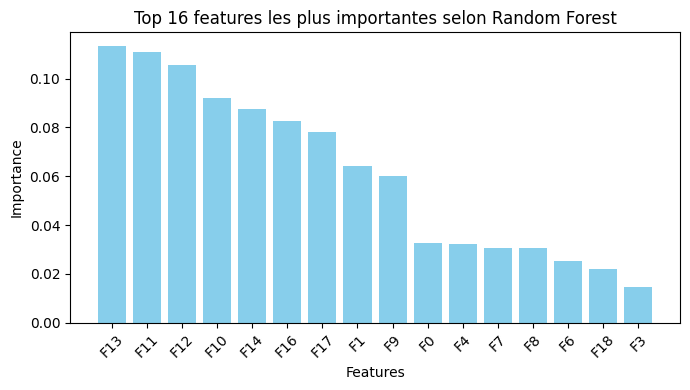

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Nombre de features à afficher
top_k = 16

# Trier les features par importance décroissante
indices_sorted = np.argsort(importances)[::-1]
sorted_importances = importances[indices_sorted]

# Créer le bar plot
plt.figure(figsize=(7,4))
plt.bar(range(top_k), sorted_importances[:top_k], color='skyblue', align='center')
plt.xticks(range(top_k), [f"F{indices_sorted[i]}" for i in range(top_k)], rotation=45)
plt.ylabel("Importance")
plt.xlabel("Features")
plt.title(f"Top {top_k} features les plus importantes selon Random Forest")
plt.tight_layout()
plt.show()


## **Corrélation**

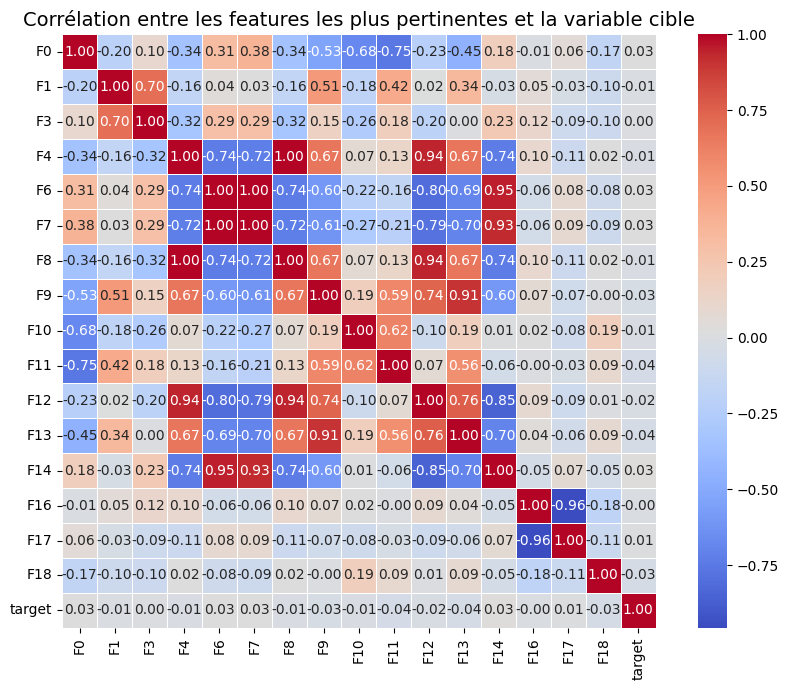

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1️ Préparer les données ---
top_n = len(selected_features)  # ou le nombre que tu veux afficher
top_feature_names = [f"F{i}" for i in selected_features]

# Créer DataFrame avec les features sélectionnées et la variable cible
X_selected_df = pd.DataFrame(X_train_selected, columns=top_feature_names)
X_selected_df["target"] = y_train  # variable cible

# --- 2️ Calculer la matrice de corrélation ---
corr_matrix = X_selected_df.corr()

# --- 3️ Visualiser la corrélation ---
plt.figure(figsize=(9,7))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5
)
plt.title("Corrélation entre les features les plus pertinentes et la variable cible", fontsize=14)
plt.tight_layout()
plt.show()


## **Entraîner le modèle final**

Accuracy sur le test : 0.7961

Classification report :
              precision    recall  f1-score   support

           0       0.24      0.08      0.12        63
           1       0.83      0.95      0.88       300

    accuracy                           0.80       363
   macro avg       0.53      0.51      0.50       363
weighted avg       0.73      0.80      0.75       363



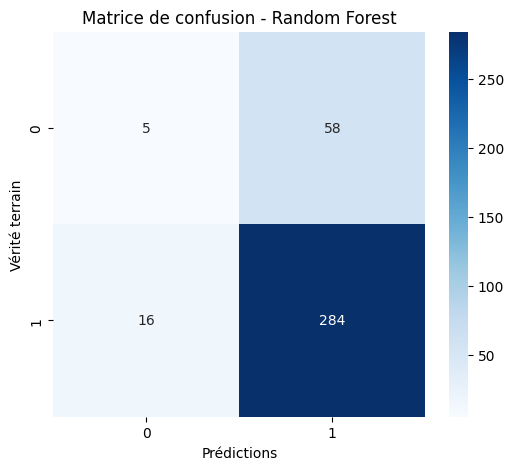

In [ ]:
from sklearn.metrics import confusion_matrix

# --- 1️. Créer le modèle Random Forest ---
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# --- 2️. Entraîner le modèle sur les features sélectionnées ---
rf_model.fit(X_train_selected, y_train)

# --- 3️. Prédire sur le jeu de test ---
y_pred = rf_model.predict(X_test_selected)

# --- 4️. Évaluer la performance ---
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy sur le test : {acc:.4f}\n")

print("Classification report :")
print(classification_report(y_test, y_pred))

# --- 5️. Matrice de confusion ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédictions")
plt.ylabel("Vérité terrain")
plt.title("Matrice de confusion - Random Forest")
plt.show()


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:33:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy sur le test : 0.7934

Classification report :
              precision    recall  f1-score   support

           0       0.25      0.10      0.14        63
           1       0.83      0.94      0.88       300

    accuracy                           0.79       363
   macro avg       0.54      0.52      0.51       363
weighted avg       0.73      0.79      0.75       363



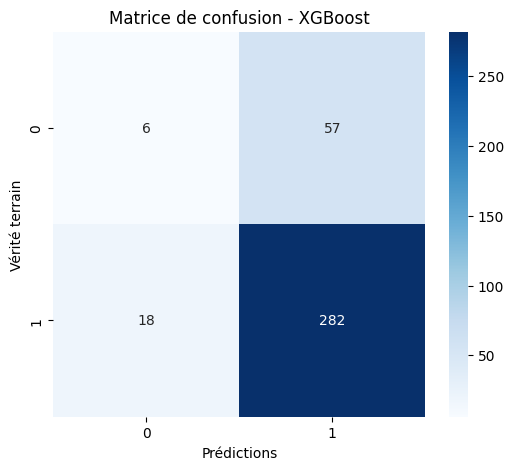

In [ ]:
# --- 1️. Créer le modèle XGBoost ---
import xgboost as xgb
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'  # pour éviter les warnings
)

# --- 2️. Entraîner le modèle sur les features sélectionnées ---
xgb_model.fit(X_train_selected, y_train)

# --- 3️. Prédire sur le jeu de test ---
y_pred = xgb_model.predict(X_test_selected)

# --- 4️. Évaluer la performance ---
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy sur le test : {acc:.4f}\n")

print("Classification report :")
print(classification_report(y_test, y_pred))

# --- 5️. Matrice de confusion ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédictions")
plt.ylabel("Vérité terrain")
plt.title("Matrice de confusion - XGBoost")
plt.show()

# **Étape 2 : Shallow embedding**

Objectif : transformer un graphe → vecteur utilisable par un modèle ML

==>il faut encoder chaque graphe en un embedding vectoriel.

Graph2Vec → embedding structurel basé sur les sous-graphes (pattern local)

  Graph2Vec capture :

*  motifs locaux

*  patterns structurels récurrents

* sous-structures clés (sous-graphes, WL-subtrees)

NetLSD → embedding spectral basé sur la diffusion de chaleur (structure globale)

Il capture :

* propriétés globales du graphe

* courbure, diamètre, forme

* distribution des chemins

| Méthode                               | Description                                                                                |
| ------------------------------------- | ------------------------------------------------------------------------------------------ |
| **Graph2Vec**                         | Inspiré de Doc2Vec : transforme chaque graphe en un vecteur basé sur des sous-structures   |
| **NetLSD**                            | Spectre Laplacien : capture la structure globale du graphe via des signatures de diffusion |
| **FGSD**                              | Feature-based Graph Spectral Descriptor : histogramme des distances spectrales             |
| **Weisfeiler-Lehman (WL) embeddings** | Compte les sous-arbres colorés du graphe sur plusieurs itérations                          |


In [ ]:
!pip install git+https://github.com/benedekrozemberczki/karateclub.git

  Cloning https://github.com/benedekrozemberczki/karateclub.git to /tmp/pip-req-build-qo03dy44
  Running command git clone --filter=blob:none --quiet https://github.com/benedekrozemberczki/karateclub.git /tmp/pip-req-build-qo03dy44
  Resolved https://github.com/benedekrozemberczki/karateclub.git to commit cb46a91df8dcbeb2570debcf6a9d0c518107a2de
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 8

## **Générer les embeddings avec Graph2Vec**

In [ ]:
import os
import pickle
import networkx as nx
import numpy as np
from karateclub import Graph2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import networkx as nx

def reindex_graph_nodes(G):
    """
    Réindexe les noeuds d'un graphe G de 0 à N-1.
    """
    mapping = {old_label: new_label for new_label, old_label in enumerate(G.nodes())}
    return nx.relabel_nodes(G, mapping)

# Réindexer tous les graphes
X_train_reindexed = [reindex_graph_nodes(G) for G in X_train]
X_test_reindexed  = [reindex_graph_nodes(G) for G in X_test]


In [ ]:
# Combiner train + test
all_graphs = X_train_reindexed + X_test_reindexed

model = Graph2Vec(dimensions=128, workers=4, wl_iterations=2)
model.fit(all_graphs)

# Récupérer les embeddings
all_embeddings = model.get_embedding()

# Séparer train et test
X_train_emb = all_embeddings[:len(X_train_reindexed)]
X_test_emb  = all_embeddings[len(X_train_reindexed):]

print("Shape X_train_emb :", X_train_emb.shape)
print("Shape X_test_emb  :", X_test_emb.shape)


/usr/local/lib/python3.12/dist-packages/karateclub/estimator.py:66: UserWarning: Please do be advised that the graph you have provided does not contain (some) edges in the main diagonal, for instance the self-loop constitued of (0, 0). These selfloops are necessary to ensure that the graph is traversable, and for this reason we create a copy of the graph and add therein the missing edges. Since we are creating a copy, this will immediately duplicate the memory requirements. To avoid this double allocation, you can provide the graph with the selfloops.
  warnings.warn(


Shape X_train_emb : (1448, 128)
Shape X_test_emb  : (363, 128)


### **Entraîner le modèle final**

Classes : [0 1]
Class weights : [2.896      0.60434057]
scale_pos_weight = 0.20868113522537562


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:34:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy sur le test : 0.7934

Classification report :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.82      0.96      0.88       300

    accuracy                           0.79       363
   macro avg       0.41      0.48      0.44       363
weighted avg       0.68      0.79      0.73       363



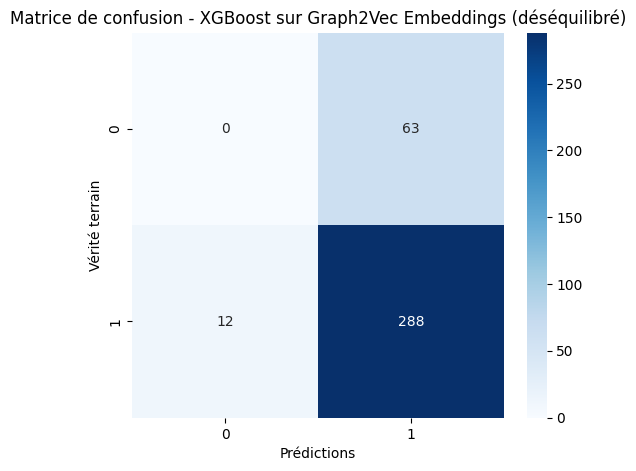

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=classes,
                                     y=y_train)
print("Classes :", classes)
print("Class weights :", class_weights)

# Pour la classification binaire, XGBoost accepte scale_pos_weight
# scale_pos_weight = poids de la classe majoritaire / poids de la classe minoritaire
if len(classes) == 2:
    n_0 = np.sum(y_train == classes[0])
    n_1 = np.sum(y_train == classes[1])
    scale_pos_weight = n_0 / n_1
    print("scale_pos_weight =", scale_pos_weight)
else:
    scale_pos_weight = 1  # Pour multi-classe, on utilisera sample_weight à la place

# -----------------------------
# 2️ Créer le modèle XGBoost
# -----------------------------
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight  # fonctionnel pour binaire
)

# -----------------------------
# 3️ Entraîner le modèle
# -----------------------------
if len(classes) > 2:
    # Multi-classe : on peut utiliser sample_weight pour équilibrer
    sample_weights = np.array([class_weights[np.where(classes==label)[0][0]] for label in y_train])
    xgb_model.fit(X_train_emb, y_train, sample_weight=sample_weights)
else:
    xgb_model.fit(X_train_emb, y_train)

# -----------------------------
# 4️ Prédire sur le jeu de test
# -----------------------------
y_pred = xgb_model.predict(X_test_emb)

# -----------------------------
# 5️ Évaluer la performance
# -----------------------------
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy sur le test : {acc:.4f}\n")

print("Classification report :")
print(classification_report(y_test, y_pred))

# -----------------------------
# 6️.Matrice de confusion
# -----------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédictions")
plt.ylabel("Vérité terrain")
plt.title("Matrice de confusion - XGBoost sur Graph2Vec Embeddings (déséquilibré)")
plt.show()


## **Générer les embeddings avec NetLSD**

In [ ]:
!pip install netlsd

In [ ]:
import numpy as np
import networkx as nx
from netlsd import heat


def remove_small_graphs(graphs, labels, min_nodes=3):
    cleaned_graphs = []
    cleaned_labels = []

    for G, label in zip(graphs, labels):
        if G.number_of_nodes() >= min_nodes:

            # Réindexer les nœuds
            G = nx.relabel_nodes(G, {old: new for new, old in enumerate(G.nodes())})

            # Ajouter self-loops
            for n in G.nodes():
                if not G.has_edge(n, n):
                    G.add_edge(n, n)

            cleaned_graphs.append(G)
            cleaned_labels.append(label)

    return cleaned_graphs, np.array(cleaned_labels)


# Nettoyage
X_train_clean, y_train_clean = remove_small_graphs(X_train, y_train)
X_test_clean, y_test_clean   = remove_small_graphs(X_test, y_test)

print("Graphes train :", len(X_train_clean))
print("Graphes test  :", len(X_test_clean))


# -----------------------------
# 3️ Appliquer NetLSD (heat)
# -----------------------------
def compute_netlsd_embeddings(graph_list):
    embeddings = []
    for G in graph_list:
        vec = heat(G)          # NetLSD signature = vecteur global
        embeddings.append(vec)
    return np.array(embeddings)


# Calcul embeddings
X_train_emb = compute_netlsd_embeddings(X_train_clean)
X_test_emb  = compute_netlsd_embeddings(X_test_clean)

print("Shape X_train_emb :", X_train_emb.shape)
print("Shape X_test_emb  :", X_test_emb.shape)


Graphes train : 1446
Graphes test  : 363
Shape X_train_emb : (1446, 250)
Shape X_test_emb  : (363, 250)


### **Entraîner le modèle final**

Accuracy sur le test : 0.7025

Classification report :
              precision    recall  f1-score   support

           0       0.12      0.11      0.11        63
           1       0.82      0.83      0.82       300

    accuracy                           0.70       363
   macro avg       0.47      0.47      0.47       363
weighted avg       0.69      0.70      0.70       363



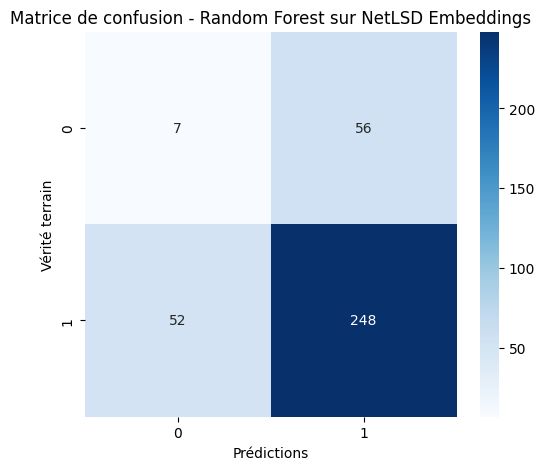

In [ ]:
# -----------------------------
# 4️ Entraîner Random Forest
# -----------------------------
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"  # pour gérer le déséquilibre
)

rf_model.fit(X_train_emb, y_train_clean)
y_pred = rf_model.predict(X_test_emb)

# -----------------------------
# 5️ Évaluation
# -----------------------------
acc = accuracy_score(y_test_clean, y_pred)
print(f"Accuracy sur le test : {acc:.4f}\n")

print("Classification report :")
print(classification_report(y_test_clean, y_pred, zero_division=0))

# Matrice de confusion
cm = confusion_matrix(y_test_clean, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédictions")
plt.ylabel("Vérité terrain")
plt.title("Matrice de confusion - Random Forest sur NetLSD Embeddings")
plt.show()

Classes : [0 1]
scale_pos_weight : 0.20903010033444816


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:38:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy sur le test : 0.6474

Classification report :
              precision    recall  f1-score   support

           0       0.14      0.21      0.17        63
           1       0.82      0.74      0.78       300

    accuracy                           0.65       363
   macro avg       0.48      0.47      0.47       363
weighted avg       0.70      0.65      0.67       363



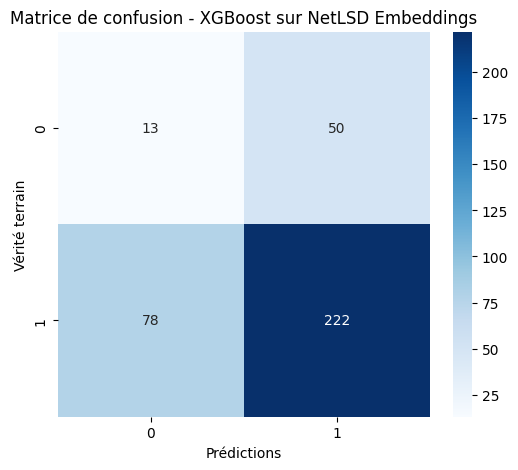

In [ ]:
# -----------------------------
# 1️ Calculer scale_pos_weight pour déséquilibre binaire
# -----------------------------
classes = np.unique(y_train_clean)
if len(classes) == 2:
    n_0 = np.sum(y_train_clean == classes[0])
    n_1 = np.sum(y_train_clean == classes[1])
    scale_pos_weight = n_0 / n_1
else:
    scale_pos_weight = 1  # multi-classe

print("Classes :", classes)
print("scale_pos_weight :", scale_pos_weight)

# -----------------------------
# 2️ Créer le modèle XGBoost
# -----------------------------
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight  # pour le binaire
)

# -----------------------------
# 3️ Entraîner le modèle
# -----------------------------
xgb_model.fit(X_train_emb, y_train_clean)

# -----------------------------
# 4️ Prédiction sur le test
# -----------------------------
y_pred = xgb_model.predict(X_test_emb)

# -----------------------------
# 5️ Évaluation
# -----------------------------
acc = accuracy_score(y_test_clean, y_pred)
print(f"Accuracy sur le test : {acc:.4f}\n")

print("Classification report :")
print(classification_report(y_test_clean, y_pred, zero_division=0))

# Matrice de confusion
cm = confusion_matrix(y_test_clean, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédictions")
plt.ylabel("Vérité terrain")
plt.title("Matrice de confusion - XGBoost sur NetLSD Embeddings")
plt.show()

# **Étape 3 : GNN**

In [ ]:
# Install PyTorch Geometric and its dependencies
import torch

def format_pytorch_version(version):
    return version.replace('+', '.post').replace('.dev', '')

torch_version = format_pytorch_version(torch.__version__)

TORCH = torch_version.split('+')[0]
CUDA = 'cu' + torch.version.cuda.replace('.', '') if torch.cuda.is_available() else ''

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}{CUDA}.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.9.0.postcu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp312-cp312-linux_x86_64.whl size=664339 sha256=5fd81841611c6b96b25f0ccbafc5b6d1f9d522f10706f66e91e28b13052cc1cf
  Stored in directory: /root/.cache/pip/wheels/84/20/50/44800723f57cd798630e77b3ec83bc80bd26a1e3dc3a672ef5
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-2.9.0.postcu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp312-cp312-linux_x86_64.whl size=1221952 sha256=fa2b9684a8c992b176cc5f483a608d78abd45d294a92d7102d79df88c7411d79
  Stored in directory: /root/.cache/pip/wheels/71/fa/21/bd1d78ce1629aec4ecc924a63b82f6949dda484b6321eac6f2
Successfully bu

In [ ]:
try:
    import torch_geometric
    print("PyG est déjà installé")
except ModuleNotFoundError:
    print("PyG non installé, il faut l'installer")

PyG est déjà installé


In [ ]:
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import numpy as np

from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

**GCN** (Graph Convolutional Network)

* GCN prend un nœud, regarde tous ses voisins, fait une moyenne de leurs features, puis met à jour le nœud.

**GraphSAGE**

* GraphSAGE fait pareil mais sans tout prendre, il échantillonne quelques voisins puis apprend comment les combiner (mean, LSTM, pooling).

 **GIN** (Graph Isomorphism Network / GINConv)

* GIN est plus agressif: il somme les features des voisins (pas juste une moyenne) et passe tout dans un MLP..

### **Conversion Graph → PyG**

In [ ]:
import torch
import numpy as np
from torch_geometric.utils import from_networkx

# -----------------------------------------
# 🔧 1) Fonction conversion NetworkX → PyG
# -----------------------------------------
def nx_to_pyg(graphs, labels, fallback_dim=4):
    pyg_graphs = []

    for i, G in enumerate(graphs):

        # ---- A) Node features ----
        node_feats = []
        for n in G.nodes():

            attr = G.nodes[n].get("attr", None)

            if attr is None:
                # Si pas de features → vecteur de zéros (4 dim par défaut)
                node_feats.append(np.zeros(fallback_dim, dtype=float))
            else:
                node_feats.append(np.asarray(attr, dtype=float))

        x_np = np.vstack(node_feats)   # (num_nodes, feat_dim)

        # ---- B) Conversion NetworkX → PyG ----
        data = from_networkx(G)

        # Sécurité : edge_index doit exister
        if not hasattr(data, "edge_index"):
            data.edge_index = torch.empty((2, 0), dtype=torch.long)

        # ---- C) Assigner les features & labels ----
        data.x = torch.tensor(x_np, dtype=torch.float)
        data.y = torch.tensor([int(labels[i])], dtype=torch.long)

        pyg_graphs.append(data)

    return pyg_graphs


# -------------------------------------------------------
# 🔥 2) Conversion après ton split (X_train, X_test, y)
# -------------------------------------------------------

pyg_train = nx_to_pyg(X_train, y_train)
pyg_test  = nx_to_pyg(X_test, y_test)

print("PyG graphs d'entraînement :", len(pyg_train))
print("PyG graphs de test       :", len(pyg_test))

print("Shape node features (exemple train) :", pyg_train[0].x.shape)
print("Edge index exemple :", pyg_train[0].edge_index[:, :10])
print("Label exemple :", pyg_train[0].y)


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  data_dict[key] = torch.as_tensor(value)


PyG graphs d'entraînement : 1448
PyG graphs de test       : 363
Shape node features (exemple train) : torch.Size([11, 4])
Edge index exemple : tensor([[0, 1, 1, 1, 2, 2, 2, 3, 3, 4],
        [1, 0, 2, 3, 1, 4, 5, 1, 6, 2]])
Label exemple : tensor([1])


### **GINConv**

Epoch 01, Loss: 0.6984, Train Acc: 0.7928, Test Acc: 0.7961
Epoch 02, Loss: 0.6960, Train Acc: 0.8273, Test Acc: 0.8264
Epoch 03, Loss: 0.6932, Train Acc: 0.8204, Test Acc: 0.8209
Epoch 04, Loss: 0.6916, Train Acc: 0.8211, Test Acc: 0.8017
Epoch 05, Loss: 0.6915, Train Acc: 0.8101, Test Acc: 0.7906
Epoch 06, Loss: 0.6924, Train Acc: 0.8198, Test Acc: 0.8044
Epoch 07, Loss: 0.6917, Train Acc: 0.8260, Test Acc: 0.8237
Epoch 08, Loss: 0.6921, Train Acc: 0.8239, Test Acc: 0.8237
Epoch 09, Loss: 0.6902, Train Acc: 0.8204, Test Acc: 0.8044
Epoch 10, Loss: 0.6901, Train Acc: 0.7693, Test Acc: 0.7548
Epoch 11, Loss: 0.6901, Train Acc: 0.6906, Test Acc: 0.6584
Epoch 12, Loss: 0.6902, Train Acc: 0.8267, Test Acc: 0.8209
Epoch 13, Loss: 0.6902, Train Acc: 0.8025, Test Acc: 0.7906
Epoch 14, Loss: 0.6887, Train Acc: 0.7486, Test Acc: 0.7245
Epoch 15, Loss: 0.6890, Train Acc: 0.8108, Test Acc: 0.7989
Epoch 16, Loss: 0.6891, Train Acc: 0.7507, Test Acc: 0.7218
Epoch 17, Loss: 0.6885, Train Acc: 0.675

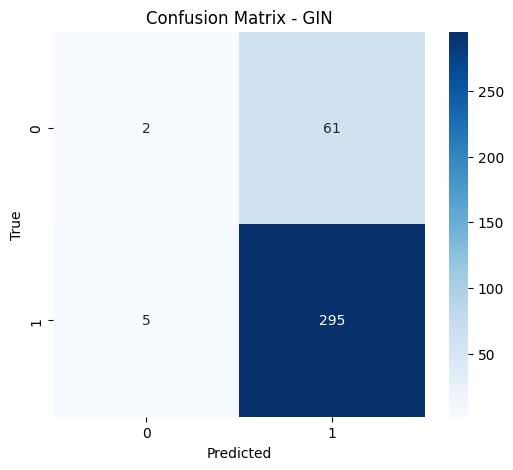

Classification Report - GIN:
               precision    recall  f1-score   support

           0       0.29      0.03      0.06        63
           1       0.83      0.98      0.90       300

    accuracy                           0.82       363
   macro avg       0.56      0.51      0.48       363
weighted avg       0.73      0.82      0.75       363



In [ ]:
from torch_geometric.nn import GINConv, global_mean_pool, Sequential
# -------------------------------
# 6️ Définir le GIN
# -------------------------------
class GIN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        # Fonction MLP pour GINConv
        def build_mlp(in_dim, hidden_dim):
            return nn.Sequential(
                nn.Linear(in_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )

        self.conv1 = GINConv(build_mlp(in_channels, hidden_channels))
        self.conv2 = GINConv(build_mlp(hidden_channels, hidden_channels))
        self.conv3 = GINConv(build_mlp(hidden_dim, hidden_channels))
        self.conv4 = GINConv(build_mlp(hidden_dim, hidden_channels))

        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x

in_channels = pyg_train[0].x.shape[1]
model = GIN(in_channels, hidden_dim, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# -------------------------------
# 7️ Fonctions train / test
# -------------------------------
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

# -------------------------------
# 8️ Entraînement
# -------------------------------
for epoch in range(1, epochs+1):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f"Epoch {epoch:02d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

# -------------------------------
# 9️ Évaluation finale avec seuil
# -------------------------------
def get_all_preds_labels(loader, threshold=0.5):
    """
    threshold : seuil pour la classe 1 (positive)
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)

            # 🔹 Softmax pour obtenir probabilités
            probs = F.softmax(out, dim=1)

            # 🔹 Prédiction avec seuil
            preds = (probs[:, 1] >= threshold).long()

            all_preds.append(preds.cpu())
            all_labels.append(data.y.cpu())
    return torch.cat(all_preds).numpy(), torch.cat(all_labels).numpy()

#  ajuster le seuil pour la classe minoritaire (ex: 0.3)
y_pred, y_true = get_all_preds_labels(test_loader, threshold=0.3)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - GIN")
plt.show()

# Classification report
report = classification_report(y_true, y_pred)
print("Classification Report - GIN:\n", report)

### **GCN**

Poids des classes : tensor([0.0040, 0.0008])
Epoch 01, Loss: 0.6946, Train Acc: 0.8191, Test Acc: 0.8099
Epoch 02, Loss: 0.6927, Train Acc: 0.7072, Test Acc: 0.6887
Epoch 03, Loss: 0.6923, Train Acc: 0.7376, Test Acc: 0.6942
Epoch 04, Loss: 0.6919, Train Acc: 0.6816, Test Acc: 0.6501
Epoch 05, Loss: 0.6935, Train Acc: 0.4883, Test Acc: 0.4380
Epoch 06, Loss: 0.6915, Train Acc: 0.7376, Test Acc: 0.7107
Epoch 07, Loss: 0.6916, Train Acc: 0.8128, Test Acc: 0.7961
Epoch 08, Loss: 0.6911, Train Acc: 0.8018, Test Acc: 0.7769
Epoch 09, Loss: 0.6905, Train Acc: 0.7721, Test Acc: 0.7328
Epoch 10, Loss: 0.6911, Train Acc: 0.8239, Test Acc: 0.8264
Epoch 11, Loss: 0.6913, Train Acc: 0.8198, Test Acc: 0.8127
Epoch 12, Loss: 0.6905, Train Acc: 0.8142, Test Acc: 0.8099
Epoch 13, Loss: 0.6901, Train Acc: 0.8011, Test Acc: 0.7796
Epoch 14, Loss: 0.6896, Train Acc: 0.6954, Test Acc: 0.6694
Epoch 15, Loss: 0.6890, Train Acc: 0.8122, Test Acc: 0.7879
Epoch 16, Loss: 0.6896, Train Acc: 0.7576, Test Acc: 0.

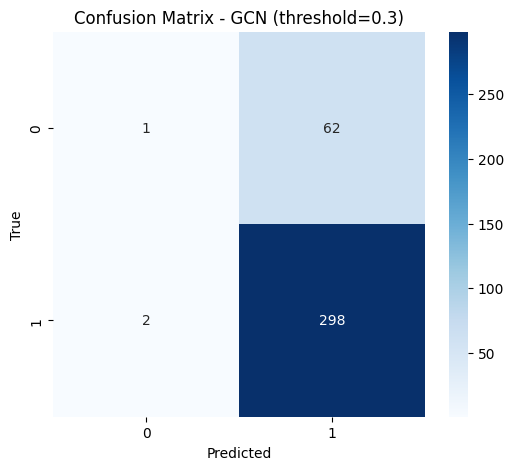

Classification Report - GCN:
               precision    recall  f1-score   support

           0       0.33      0.02      0.03        63
           1       0.83      0.99      0.90       300

    accuracy                           0.82       363
   macro avg       0.58      0.50      0.47       363
weighted avg       0.74      0.82      0.75       363



In [ ]:
# -------------------------------
# 3️ Hyperparamètres
# -------------------------------
batch_size = 32
hidden_dim = 64
num_classes = 2
epochs = 50
lr = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -------------------------------
# 4️ DataLoader
# -------------------------------
train_loader = DataLoader(pyg_train, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(pyg_test, batch_size=batch_size)

# -------------------------------
# 5️ Calcul des poids pour CrossEntropyLoss
# -------------------------------
all_labels = np.array([g.y.item() for g in pyg_train])
class_counts = np.bincount(all_labels)
class_weights = 1.0 / class_counts
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

print("Poids des classes :", class_weights)

# -------------------------------
# 6️ Définir le GCN
# -------------------------------
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        self.conv6 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = self.conv6(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x

in_channels = pyg_train[0].x.shape[1]
model = GCN(in_channels, hidden_dim, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# -------------------------------
# 7️⃣ Fonctions train / test
# -------------------------------
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

# -------------------------------
# 8️⃣ Entraînement
# -------------------------------
for epoch in range(1, epochs+1):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f"Epoch {epoch:02d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

# -------------------------------
# 9️⃣ Évaluation finale
# -------------------------------
def get_all_preds_labels(loader, threshold=0.5):
    """
    threshold : seuil pour la classe 1 (positive)
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)

            # 🔹 Softmax pour obtenir probabilités
            probs = F.softmax(out, dim=1)

            # 🔹 Prédiction avec seuil
            preds = (probs[:, 1] >= threshold).long()

            all_preds.append(preds.cpu())
            all_labels.append(data.y.cpu())
    return torch.cat(all_preds).numpy(), torch.cat(all_labels).numpy()

# Ajuste le seuil pour la classe minoritaire (exemple threshold=0.3)
y_pred, y_true = get_all_preds_labels(test_loader, threshold=0.3)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - GCN (threshold=0.3)")
plt.show()

# Classification report
report = classification_report(y_true, y_pred)
print("Classification Report - GCN:\n", report)

### **GraphSAGE**

Poids des classes : tensor([0.0040, 0.0008])
Epoch 01, Loss: 0.7003, Train Acc: 0.8198, Test Acc: 0.8182
Epoch 02, Loss: 0.6914, Train Acc: 0.8163, Test Acc: 0.8127
Epoch 03, Loss: 0.6909, Train Acc: 0.8253, Test Acc: 0.8182
Epoch 04, Loss: 0.6925, Train Acc: 0.8156, Test Acc: 0.8127
Epoch 05, Loss: 0.6931, Train Acc: 0.8135, Test Acc: 0.8182
Epoch 06, Loss: 0.6914, Train Acc: 0.8156, Test Acc: 0.8127
Epoch 07, Loss: 0.6896, Train Acc: 0.8156, Test Acc: 0.8099
Epoch 08, Loss: 0.6900, Train Acc: 0.7231, Test Acc: 0.6887
Epoch 09, Loss: 0.6914, Train Acc: 0.8156, Test Acc: 0.8154
Epoch 10, Loss: 0.6902, Train Acc: 0.8211, Test Acc: 0.8237
Epoch 11, Loss: 0.6905, Train Acc: 0.8163, Test Acc: 0.8209
Epoch 12, Loss: 0.6896, Train Acc: 0.8170, Test Acc: 0.8127
Epoch 13, Loss: 0.6892, Train Acc: 0.8156, Test Acc: 0.8044
Epoch 14, Loss: 0.6879, Train Acc: 0.7756, Test Acc: 0.7548
Epoch 15, Loss: 0.6882, Train Acc: 0.8046, Test Acc: 0.7796
Epoch 16, Loss: 0.6900, Train Acc: 0.7438, Test Acc: 0.

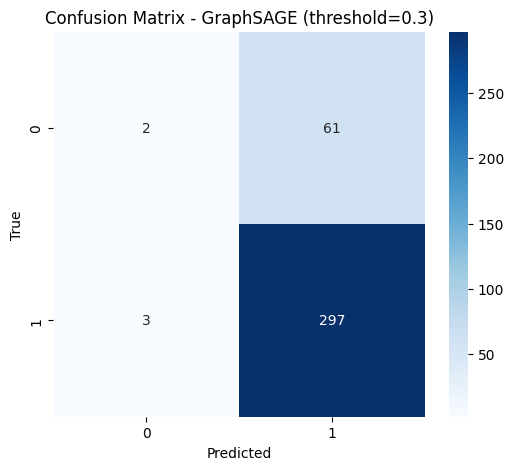

Classification Report - GraphSAGE:
               precision    recall  f1-score   support

           0       0.40      0.03      0.06        63
           1       0.83      0.99      0.90       300

    accuracy                           0.82       363
   macro avg       0.61      0.51      0.48       363
weighted avg       0.76      0.82      0.76       363



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -------------------------------
# 1️ Conversion NetworkX → PyG
# -------------------------------
def nx_to_pyg(graphs, labels, fallback_dim=4):
    pyg_graphs = []
    for i, G in enumerate(graphs):
        node_feats = []
        for n in G.nodes():
            attr = G.nodes[n].get("attr", None)
            if attr is None:
                node_feats.append(np.zeros(fallback_dim, dtype=float))
            else:
                node_feats.append(np.asarray(attr, dtype=float))
        x_np = np.vstack(node_feats)
        data = from_networkx(G)
        if not hasattr(data, "edge_index"):
            data.edge_index = torch.empty((2,0), dtype=torch.long)
        data.x = torch.tensor(x_np, dtype=torch.float)
        data.y = torch.tensor([int(labels[i])], dtype=torch.long)
        pyg_graphs.append(data)
    return pyg_graphs

# -------------------------------------------------------
# 2️ Conversion après split (X_train, X_test, y)
# -------------------------------------------------------
pyg_train = nx_to_pyg(X_train, y_train)
pyg_test  = nx_to_pyg(X_test, y_test)

# -------------------------------
# 3️ Hyperparamètres
# -------------------------------
batch_size = 32
hidden_dim = 64
num_classes = 2
epochs = 50
lr = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -------------------------------
# 4️ DataLoader
# -------------------------------
train_loader = DataLoader(pyg_train, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(pyg_test, batch_size=batch_size)

# -------------------------------
# 5️ Calcul des poids pour CrossEntropyLoss
# -------------------------------
all_labels = np.array([g.y.item() for g in pyg_train])
class_counts = np.bincount(all_labels)
class_weights = 1.0 / class_counts
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
print("Poids des classes :", class_weights)

# -------------------------------
# 6️ Définir le GraphSAGE
# -------------------------------
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x

in_channels = pyg_train[0].x.shape[1]
model = GraphSAGE(in_channels, hidden_dim, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# -------------------------------
# 7️ Fonctions train / test
# -------------------------------
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

# -------------------------------
# 8️ Entraînement
# -------------------------------
for epoch in range(1, epochs+1):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f"Epoch {epoch:02d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

# -------------------------------
# 9️ Évaluation finale avec seuil
# -------------------------------
def get_all_preds_labels(loader, threshold=0.5):
    """
    threshold: seuil pour la classe 1 (positive)
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)

            # 🔹 Appliquer softmax pour obtenir probabilités
            probs = F.softmax(out, dim=1)

            # 🔹 Prédiction avec seuil sur la classe 1
            preds = (probs[:, 1] >= threshold).long()

            all_preds.append(preds.cpu())
            all_labels.append(data.y.cpu())
    return torch.cat(all_preds).numpy(), torch.cat(all_labels).numpy()

# Ajuste le seuil selon le déséquilibre
y_pred, y_true = get_all_preds_labels(test_loader, threshold=0.3)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - GraphSAGE (threshold=0.3)")
plt.show()

# Classification report
report = classification_report(y_true, y_pred)
print("Classification Report - GraphSAGE:\n", report)
